In [1]:
import pandas as pd
import numpy as np
import calendar
from time import time
from datetime import datetime
import re 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.metrics import log_loss, accuracy_score, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_train = pd.read_csv("train.csv").replace("MENS WEAR","MENSWEAR")
#data_train_orig = pd.read_csv("train.csv").replace("MENS WEAR","MENSWEAR")

In [3]:
dept_list = sorted(list(data_train.DepartmentDescription.dropna().unique()))

In [4]:
weekdays = list(calendar.day_name)
dept_list_sum = dict.fromkeys(dept_list, np.sum)
weekday_dict = dict.fromkeys(weekdays, np.max)
feature_dict = {"TripType": np.max, 'NumItems': np.sum, 'Return': np.max}
feature_dict = {**feature_dict, **weekday_dict, **dept_list_sum}

In [5]:
def transform_data(data):
    dummies = pd.get_dummies(data.Weekday)
    data[dummies.columns] = dummies
    
    dummies = pd.get_dummies(data.DepartmentDescription)
    dummies = dummies.apply(lambda x: x*data["ScanCount"])
    data[dummies.columns] = dummies 

    data.loc[data.ScanCount < 0, 'Return'] = 1
    data.loc[data.Return != 1, 'Return'] = 0
    
    data = data.rename(columns={"ScanCount":"NumItems"})
    
    grouped = data.groupby("VisitNumber")
    grouped = grouped.aggregate(feature_dict)
    data = grouped[["TripType", "NumItems", "Return"] + weekdays + dept_list]

    return data

In [6]:
data_new = transform_data(data_train)

In [7]:
def add_category_counts(data):
    alist = []
    for array in np.asarray(data.loc[:, dept_list[0]:]):
        count = 0
        count = sum(x > 0 for x in array)
        alist.append(count)
    cat_counts = pd.DataFrame(alist)
    cat_counts = cat_counts.rename(columns={0:"CategoryCount"})
    cat_counts = cat_counts.set_index(data.index)
    data.insert(3, 'CategoryCounts', cat_counts)
    return data

In [8]:
data_new = add_category_counts(data_new)

In [9]:
data_new.shape

(95674, 78)

In [10]:
def fineline_dummies(data):
    values = data.FinelineNumber
    counts = values.value_counts()
    mask = values.isin(counts[counts > 500].index)
    values[~mask] = "-"
    dummies = pd.get_dummies(values).drop('-', axis=1)

    dummies.columns = ['fln_'+str(col) for col in dummies.columns]
    dummies = pd.concat([dummies, data.VisitNumber], axis=1)
    dummies = dummies.groupby("VisitNumber")
    dummies = dummies.aggregate(np.sum)
    return dummies

In [11]:
start = datetime.now()
fln_dummies = fineline_dummies(data_train)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


'0:00:19.535202'

In [12]:
data_new = data_new.join(fln_dummies)

In [13]:
data_new.shape

(95674, 351)

In [14]:
def Upc_dummies(data):
    values = data.Upc
    counts = values.value_counts()
    mask = values.isin(counts[counts > 300].index)
    values[~mask] = "-"
    dummies = pd.get_dummies(values).drop('-', axis=1)

    dummies.columns = ['upc_'+str(col) for col in dummies.columns]
    dummies = pd.concat([dummies, data.VisitNumber], axis=1)
    dummies = dummies.groupby("VisitNumber")
    dummies = dummies.aggregate(np.sum)
    return dummies

In [15]:
start = datetime.now()
upc_dummies = Upc_dummies(data_train)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


'0:00:07.738239'

In [16]:
data_new = data_new.join(upc_dummies)

In [17]:
data_new.shape

(95674, 451)

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [19]:
X = data_new.drop('TripType', axis=1)

trip_types = sorted(data_train.TripType.unique())
trip_types_map = dict(zip(trip_types, np.arange(0, len(trip_types))))
y = data_new.TripType.map(trip_types_map)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [20]:
len(X.columns)

450

In [21]:
def create_model_4hl(nodes_l1=512, nodes_l2=256, nodes_l3=128, nodes_l4=64, dropout_l1=0.3, dropout_l2=0.3, dropout_l3=0.2, dropout_l4=0.2):
    model = Sequential()
    model.add(Dense(output_dim=nodes_l1, activation="relu", input_dim=len(X.columns)))
    model.add(Dropout(dropout_l1))
    model.add(Dense(output_dim=nodes_l2, activation="relu"))
    model.add(Dropout(dropout_l2))
    model.add(Dense(output_dim=nodes_l3, activation="relu"))
    model.add(Dropout(dropout_l3))
    model.add(Dense(output_dim=nodes_l4, activation="relu"))
    model.add(Dropout(dropout_l3))
            
    model.add(Dense(output_dim=len(trip_types), activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    
    return model

In [22]:
model_4hl = KerasClassifier(build_fn=create_model_4hl, epochs=70, batch_size=1000, verbose=2)

In [23]:
callbacks = [EarlyStopping(monitor="val_acc", patience=20), 
             ModelCheckpoint(filepath="best_model.h5", monitor="val_acc", save_best_only=True)]

In [24]:
start = datetime.now()
hist_4hl_a = model_4hl.fit(X, y, validation_split=0.25, epochs=100, callbacks=callbacks)
end = datetime.now()
str(end-start)

W0911 12:33:32.019976  7888 deprecation_wrapper.py:119] From C:\Users\Xiuquan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
W0911 12:33:33.338793  7888 deprecation_wrapper.py:119] From C:\Users\Xiuquan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0911 12:33:33.576646  7888 deprecation_wrapper.py:119] From C:\Users\Xiuquan\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0911 12:33:33.679581  7888 depre

Train on 71755 samples, validate on 23919 samples
Epoch 1/100
 - 16s - loss: 2.2665 - acc: 0.4013 - val_loss: 1.3694 - val_acc: 0.6203
Epoch 2/100
 - 13s - loss: 1.4656 - acc: 0.5970 - val_loss: 1.1624 - val_acc: 0.6693
Epoch 3/100
 - 13s - loss: 1.2737 - acc: 0.6417 - val_loss: 1.0659 - val_acc: 0.6790
Epoch 4/100
 - 13s - loss: 1.1692 - acc: 0.6643 - val_loss: 0.9846 - val_acc: 0.7048
Epoch 5/100
 - 13s - loss: 1.1049 - acc: 0.6781 - val_loss: 0.9319 - val_acc: 0.7147
Epoch 6/100
 - 12s - loss: 1.0582 - acc: 0.6852 - val_loss: 0.9124 - val_acc: 0.7177
Epoch 7/100
 - 11s - loss: 1.0156 - acc: 0.6962 - val_loss: 0.9029 - val_acc: 0.7177
Epoch 8/100
 - 12s - loss: 0.9824 - acc: 0.7052 - val_loss: 0.8799 - val_acc: 0.7229
Epoch 9/100
 - 11s - loss: 0.9554 - acc: 0.7085 - val_loss: 0.8659 - val_acc: 0.7281
Epoch 10/100
 - 11s - loss: 0.9288 - acc: 0.7158 - val_loss: 0.8763 - val_acc: 0.7193
Epoch 11/100
 - 12s - loss: 0.9071 - acc: 0.7205 - val_loss: 0.8546 - val_acc: 0.7271
Epoch 12/100


'0:07:59.710780'

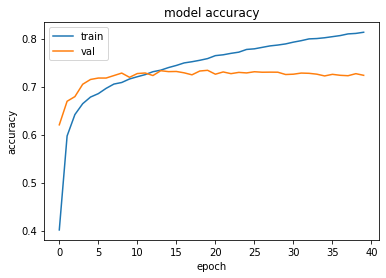

In [26]:
plt.plot(hist_4hl_a.history['acc'])
plt.plot(hist_4hl_a.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

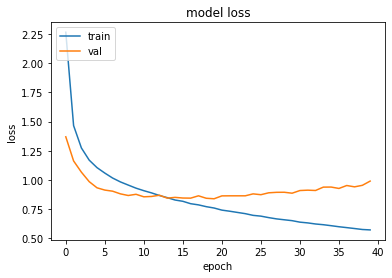

In [27]:
plt.plot(hist_4hl_a.history['loss'])
plt.plot(hist_4hl_a.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
scoring = ['accuracy', 'neg_log_loss']
cv = StratifiedKFold(n_splits=4)

In [29]:
nn_4hl = KerasClassifier(build_fn=create_model_4hl, epochs=20, batch_size=1000, verbose=2)

In [30]:
start = datetime.now()
hist_cross_val = cross_validate(nn_4hl, X, y, scoring=scoring, cv=cv)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  if __name__ == '__main__':
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  if sys.path[0] == '':

Epoch 1/20
 - 10s - loss: 2.2394 - acc: 0.3963
Epoch 2/20
 - 10s - loss: 1.4596 - acc: 0.6000
Epoch 3/20
 - 10s - loss: 1.2612 - acc: 0.6442
Epoch 4/20
 - 10s - loss: 1.1608 - acc: 0.6639
Epoch 5/20
 - 11s - loss: 1.0984 - acc: 0.6783
Epoch 6/20
 - 11s - loss: 1.0581 - acc: 0.6860
Epoch 7/20
 - 10s - loss: 1.0127 - acc: 0.6958
Epoch 8/20
 - 10s - loss: 0.9837 - acc: 0.7015
Epoch 9/20
 - 11s - loss: 0.9504 - acc: 0.7096
Epoch 10/20
 - 10s - loss: 0.9332 - acc: 0.7134
Epoch 11/20
 - 10s - loss: 0.9093 - acc: 0.7189
Epoch 12/20
 - 9s - loss: 0.8830 - acc: 0.7253
Epoch 13/20
 - 9s - loss: 0.8640 - acc: 0.7297
Epoch 14/20
 - 10s - loss: 0.8470 - acc: 0.7333
Epoch 15/20
 - 9s - loss: 0.8324 - acc: 0.7363
Epoch 16/20
 - 10s - loss: 0.8095 - acc: 0.7433
Epoch 17/20
 - 10s - loss: 0.7939 - acc: 0.7481
Epoch 18/20
 - 9s - loss: 0.7811 - acc: 0.7516
Epoch 19/20
 - 10s - loss: 0.7678 - acc: 0.7549
Epoch 20/20
 - 9s - loss: 0.7564 - acc: 0.7576


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  if __name__ == '__main__':
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  if sys.path[0] == '':

Epoch 1/20
 - 10s - loss: 2.2420 - acc: 0.4077
Epoch 2/20
 - 10s - loss: 1.4608 - acc: 0.5990
Epoch 3/20
 - 10s - loss: 1.2604 - acc: 0.6411
Epoch 4/20
 - 10s - loss: 1.1507 - acc: 0.6651
Epoch 5/20
 - 10s - loss: 1.0972 - acc: 0.6759
Epoch 6/20
 - 9s - loss: 1.0432 - acc: 0.6885
Epoch 7/20
 - 10s - loss: 1.0073 - acc: 0.6965
Epoch 8/20
 - 11s - loss: 0.9754 - acc: 0.7038
Epoch 9/20
 - 9s - loss: 0.9485 - acc: 0.7100
Epoch 10/20
 - 10s - loss: 0.9285 - acc: 0.7142
Epoch 11/20
 - 10s - loss: 0.9015 - acc: 0.7215
Epoch 12/20
 - 10s - loss: 0.8789 - acc: 0.7270
Epoch 13/20
 - 10s - loss: 0.8571 - acc: 0.7339
Epoch 14/20
 - 10s - loss: 0.8428 - acc: 0.7367
Epoch 15/20
 - 10s - loss: 0.8246 - acc: 0.7410
Epoch 16/20
 - 11s - loss: 0.8095 - acc: 0.7454
Epoch 17/20
 - 10s - loss: 0.7950 - acc: 0.7471
Epoch 18/20
 - 11s - loss: 0.7769 - acc: 0.7539
Epoch 19/20
 - 9s - loss: 0.7624 - acc: 0.7565
Epoch 20/20
 - 10s - loss: 0.7529 - acc: 0.7593


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  if __name__ == '__main__':
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  if sys.path[0] == '':

Epoch 1/20
 - 9s - loss: 2.2257 - acc: 0.4009
Epoch 2/20
 - 10s - loss: 1.4274 - acc: 0.6071
Epoch 3/20
 - 9s - loss: 1.2425 - acc: 0.6463
Epoch 4/20
 - 9s - loss: 1.1376 - acc: 0.6691
Epoch 5/20
 - 9s - loss: 1.0748 - acc: 0.6836
Epoch 6/20
 - 10s - loss: 1.0304 - acc: 0.6930
Epoch 7/20
 - 10s - loss: 0.9855 - acc: 0.7027
Epoch 8/20
 - 9s - loss: 0.9586 - acc: 0.7097
Epoch 9/20
 - 10s - loss: 0.9303 - acc: 0.7158
Epoch 10/20
 - 9s - loss: 0.9040 - acc: 0.7224
Epoch 11/20
 - 10s - loss: 0.8830 - acc: 0.7260
Epoch 12/20
 - 10s - loss: 0.8632 - acc: 0.7300
Epoch 13/20
 - 10s - loss: 0.8397 - acc: 0.7385
Epoch 14/20
 - 10s - loss: 0.8236 - acc: 0.7415
Epoch 15/20
 - 8s - loss: 0.8107 - acc: 0.7437
Epoch 16/20
 - 10s - loss: 0.7905 - acc: 0.7488
Epoch 17/20
 - 9s - loss: 0.7752 - acc: 0.7537
Epoch 18/20
 - 10s - loss: 0.7648 - acc: 0.7570
Epoch 19/20
 - 10s - loss: 0.7469 - acc: 0.7622
Epoch 20/20
 - 9s - loss: 0.7376 - acc: 0.7641


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  if __name__ == '__main__':
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  if sys.path[0] == '':

Epoch 1/20
 - 10s - loss: 2.2448 - acc: 0.4031
Epoch 2/20
 - 11s - loss: 1.4507 - acc: 0.6018
Epoch 3/20
 - 11s - loss: 1.2631 - acc: 0.6416
Epoch 4/20
 - 10s - loss: 1.1573 - acc: 0.6627
Epoch 5/20
 - 10s - loss: 1.0965 - acc: 0.6762
Epoch 6/20
 - 9s - loss: 1.0468 - acc: 0.6874
Epoch 7/20
 - 9s - loss: 1.0048 - acc: 0.6964
Epoch 8/20
 - 9s - loss: 0.9820 - acc: 0.7030
Epoch 9/20
 - 10s - loss: 0.9481 - acc: 0.7110
Epoch 10/20
 - 10s - loss: 0.9162 - acc: 0.7159
Epoch 11/20
 - 9s - loss: 0.9005 - acc: 0.7215
Epoch 12/20
 - 9s - loss: 0.8818 - acc: 0.7259
Epoch 13/20
 - 9s - loss: 0.8578 - acc: 0.7317
Epoch 14/20
 - 9s - loss: 0.8393 - acc: 0.7361
Epoch 15/20
 - 9s - loss: 0.8217 - acc: 0.7402
Epoch 16/20
 - 9s - loss: 0.8104 - acc: 0.7433
Epoch 17/20
 - 9s - loss: 0.7976 - acc: 0.7474
Epoch 18/20
 - 9s - loss: 0.7754 - acc: 0.7525
Epoch 19/20
 - 9s - loss: 0.7669 - acc: 0.7542
Epoch 20/20
 - 9s - loss: 0.7546 - acc: 0.7584


'0:13:15.897387'

In [31]:
hist_cross_val

{'fit_time': array([200.58756852, 203.00107884, 191.14137602, 190.39683914]),
 'score_time': array([2.72032475, 2.34955335, 2.60854077, 2.78828406]),
 'test_accuracy': array([0.72657001, 0.72597299, 0.71527139, 0.73307956]),
 'test_neg_log_loss': array([-0.85951196, -0.86465922, -0.92148312, -0.84053305])}

In [32]:
hist_cross_val['test_accuracy'].mean(), hist_cross_val['test_neg_log_loss'].mean()

(0.7252234882849065, -0.8715468387687827)

In [33]:
nn_4hl = KerasClassifier(build_fn=create_model_4hl, epochs=15, batch_size=1000, verbose=2)

In [34]:
start = datetime.now()
hist_cross_val_v2 = cross_validate(nn_4hl, X, y, scoring=scoring, cv=cv)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  if __name__ == '__main__':
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  if sys.path[0] == '':

Epoch 1/15
 - 9s - loss: 2.2069 - acc: 0.4149
Epoch 2/15
 - 7s - loss: 1.4447 - acc: 0.6031
Epoch 3/15
 - 8s - loss: 1.2613 - acc: 0.6445
Epoch 4/15
 - 8s - loss: 1.1542 - acc: 0.6662
Epoch 5/15
 - 8s - loss: 1.0965 - acc: 0.6758
Epoch 6/15
 - 8s - loss: 1.0442 - acc: 0.6882
Epoch 7/15
 - 9s - loss: 1.0046 - acc: 0.6967
Epoch 8/15
 - 7s - loss: 0.9791 - acc: 0.7020
Epoch 9/15
 - 9s - loss: 0.9464 - acc: 0.7107
Epoch 10/15
 - 9s - loss: 0.9177 - acc: 0.7182
Epoch 11/15
 - 9s - loss: 0.8985 - acc: 0.7223
Epoch 12/15
 - 9s - loss: 0.8792 - acc: 0.7254
Epoch 13/15
 - 9s - loss: 0.8631 - acc: 0.7307
Epoch 14/15
 - 10s - loss: 0.8377 - acc: 0.7367
Epoch 15/15
 - 9s - loss: 0.8242 - acc: 0.7403


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  if __name__ == '__main__':
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  if sys.path[0] == '':

Epoch 1/15
 - 10s - loss: 2.2244 - acc: 0.4106
Epoch 2/15
 - 11s - loss: 1.4675 - acc: 0.5987
Epoch 3/15
 - 10s - loss: 1.2677 - acc: 0.6432
Epoch 4/15
 - 11s - loss: 1.1681 - acc: 0.6633
Epoch 5/15
 - 9s - loss: 1.1018 - acc: 0.6770
Epoch 6/15
 - 9s - loss: 1.0502 - acc: 0.6877
Epoch 7/15
 - 10s - loss: 1.0110 - acc: 0.6956
Epoch 8/15
 - 12s - loss: 0.9810 - acc: 0.7027
Epoch 9/15
 - 11s - loss: 0.9531 - acc: 0.7081
Epoch 10/15
 - 13s - loss: 0.9242 - acc: 0.7157
Epoch 11/15
 - 14s - loss: 0.9041 - acc: 0.7210
Epoch 12/15
 - 10s - loss: 0.8809 - acc: 0.7269
Epoch 13/15
 - 11s - loss: 0.8614 - acc: 0.7303
Epoch 14/15
 - 11s - loss: 0.8426 - acc: 0.7352
Epoch 15/15
 - 12s - loss: 0.8280 - acc: 0.7400


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  if __name__ == '__main__':
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  if sys.path[0] == '':

Epoch 1/15
 - 11s - loss: 2.2578 - acc: 0.4053
Epoch 2/15
 - 9s - loss: 1.4409 - acc: 0.6049
Epoch 3/15
 - 11s - loss: 1.2357 - acc: 0.6501
Epoch 4/15
 - 11s - loss: 1.1334 - acc: 0.6709
Epoch 5/15
 - 9s - loss: 1.0705 - acc: 0.6850
Epoch 6/15
 - 9s - loss: 1.0239 - acc: 0.6938
Epoch 7/15
 - 9s - loss: 0.9876 - acc: 0.7030
Epoch 8/15
 - 9s - loss: 0.9526 - acc: 0.7100
Epoch 9/15
 - 9s - loss: 0.9277 - acc: 0.7154
Epoch 10/15
 - 9s - loss: 0.8999 - acc: 0.7224
Epoch 11/15
 - 11s - loss: 0.8771 - acc: 0.7268
Epoch 12/15
 - 11s - loss: 0.8576 - acc: 0.7333
Epoch 13/15
 - 11s - loss: 0.8385 - acc: 0.7381
Epoch 14/15
 - 10s - loss: 0.8217 - acc: 0.7439
Epoch 15/15
 - 11s - loss: 0.8025 - acc: 0.7482


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=256)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  if __name__ == '__main__':
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  if sys.path[0] == '':

Epoch 1/15
 - 12s - loss: 2.2332 - acc: 0.4110
Epoch 2/15
 - 14s - loss: 1.4572 - acc: 0.6018
Epoch 3/15
 - 13s - loss: 1.2629 - acc: 0.6433
Epoch 4/15
 - 14s - loss: 1.1562 - acc: 0.6640
Epoch 5/15
 - 14s - loss: 1.0918 - acc: 0.6786
Epoch 6/15
 - 13s - loss: 1.0399 - acc: 0.6896
Epoch 7/15
 - 12s - loss: 0.9987 - acc: 0.6988
Epoch 8/15
 - 11s - loss: 0.9717 - acc: 0.7036
Epoch 9/15
 - 12s - loss: 0.9420 - acc: 0.7107
Epoch 10/15
 - 11s - loss: 0.9209 - acc: 0.7162
Epoch 11/15
 - 13s - loss: 0.8958 - acc: 0.7220
Epoch 12/15
 - 11s - loss: 0.8799 - acc: 0.7254
Epoch 13/15
 - 11s - loss: 0.8573 - acc: 0.7313
Epoch 14/15
 - 11s - loss: 0.8424 - acc: 0.7366
Epoch 15/15
 - 11s - loss: 0.8252 - acc: 0.7401


'0:10:43.635580'

In [36]:
hist_cross_val_v2

{'fit_time': array([130.2818687 , 166.12338614, 150.34848142, 185.14223909]),
 'score_time': array([2.42950368, 3.01914048, 3.10908747, 2.91204023]),
 'test_accuracy': array([0.72769816, 0.71840642, 0.71430961, 0.73069522]),
 'test_neg_log_loss': array([-0.85651473, -0.8751064 , -0.90993035, -0.835998  ])}

In [37]:
hist_cross_val_v2['test_accuracy'].mean(), hist_cross_val_v2['test_neg_log_loss'].mean()

(0.722777352720644, -0.8693873665420062)